# [2주차] 기본과제 - 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

In [35]:
!pip install -q datasets sacremoses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    # 기존
    # labels.append(row['label'])
    # texts.append(row['text'])
    
    # TODO: 변화 하는 점
    # 문장의 마지막 3개 토큰 중, “-3” 위치를 label로 지정
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-3])
    # 마지막 3개 토큰 전까지를 입력 텐서로 이용
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))

  # 기존
  # texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  # labels = torch.LongTensor(labels)
  
  # TODO: 변화 하는 점
  # Pad 처리
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [72]:
batch_sizes = [64, 128, 256, 512, 1024, 2048]
lr = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]

batch_size = batch_sizes[2]

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [37]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    # 입력 벡터 차원(32)
    self.input_dim = input_dim

    # Query / Key / Value 및 최종 출력의 차원 (32)
    # Q, K, V를 구하기 위한 선형 변환(가중치 Wq, Wk, Wv)
    self.d_model = d_model

    # Query / Key / Value 벡터를 만들기 위한 가중치 행렬값
    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)

    # Self-Attention 결과를 다음 레이어로 넘기기 전에 선형 변환
    # 최종 출력에 다시 한 번 선형 변환
    self.dense = nn.Linear(d_model, d_model)

    # Self-Attention score 정의 (마지막 차원), softmax
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    # x shape: (B, S, D)
    # Query / Key / Value 벡터 생성
    q, k, v = self.wq(x), self.wk(x), self.wv(x)

    # score = Q * K^T
    # Q(B, S, D) * K^T(B, D, S) = (B, S, S)
    # single.self-attention
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)

    # scaling = Q * K^T / 루트 차원수 , d_model로 sacle
    score = score / sqrt(self.d_model)

    # Attention 계산시 무의미한 패딩값을 제외하기 위해 마스킹
    if mask is not None:
      # padding 위치(mask)에 해당하는 score에 -1e9를 더해 무시하도록 만든다.
      score = score + (mask * -1e9)

    # Attention 점수를 확률로 변경
    score = self.softmax(score)

    # Attention Score를 각 Value 벡터에 곱해 가중합 (문맥을 반영한 최종 벡터)
    # Attention (Q, K, V) = softmax(QK^T / sqrt(d_model)) * V
    # => (B, S, S) * (B, S, d_model) = (B, S, d_model)
    result = torch.matmul(score, v)

    # 최종 선형 변환
    # 특징 벡터 (최종 벡터)
    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [38]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    # 입력 벡터 차원
    self.input_dim = input_dim

    # 모델 내부에서 사용하는 차원 (Self-Attention 연산 시 사용되는 차원)
    self.d_model = d_model

    # Feed Forward 네트워크 내부에서 사용하는 은닉층 차원
    self.dff = dff

    # 1) Self-Attention
    self.sa = SelfAttention(input_dim, d_model)

    # 2) Feed-Forward Network (FFN)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    # Self-Attention
    x = self.sa(x, mask)
    # Feed Forward
    x = self.ffn(x)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [39]:
import numpy as np


def get_angles(pos, i, d_model):
    # 수식 변환
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    # 수식 변환
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)

    # 짝수
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 홀수
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # 차원추가해 형태 맞추기
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [40]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    # (1) 임베딩 레이어
    self.embedding = nn.Embedding(vocab_size, d_model)
    # (2) Positional Encoding
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    # (3) Transformer Layers
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    
    # (4) 분류용 최종 Linear 
    # self.classification = nn.Linear(d_model, 1)
    
    #  TODO: 변화 하는 점 
    # 출력 벡터 차원을 토큰 수로 변경
    self.classification = nn.Linear(d_model, len(tokenizer))

  def forward(self, x):
    # x shape: (B S)

    # 1) Mask 준비 => (B, S) -> (B, 1, S)
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :] # broadcasting을 위해 차원 추가

    # 2) Embedding & Positional Encoding
    seq_len = x.shape[1]
    x = self.embedding(x) # (B, S, d_model)
    x = x * sqrt(self.d_model) # 스케일링
    x = x + self.pos_encoding[:, :seq_len]

    # 3) Stacked Transformer Layers
    for layer in self.layers:
      x = layer(x, mask)

    # 4) 최종으로 [CLS] 위치(여기선 x[:, 0])만 꺼내서 Linear 통과
    x = x[:, 0] # (B, d_model)
    x = self.classification(x) # (B, 1)

    return x

# 모델 인스턴스 만들기
model = TextClassifier(len(tokenizer), 32, 2, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습 (GPU 도 조절)

# GPU 활용해보기
batch_size, learning rate 조절해보기

In [93]:
import math

# 배치 크기 옵션
batch_sizes = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

# 기준 학습률 (기본값: 배치 크기 64일 때 0.001)
base_batch_size = 64
base_lr = 0.001

# 각 배치 크기에 맞는 학습률 계산 (제곱근 스케일링 적용)
scaled_lrs = [base_lr * math.sqrt(bs / base_batch_size) for bs in batch_sizes]

# 계산된 학습률 출력
for bs, lr in zip(batch_sizes, scaled_lrs):
    print(f"배치 크기: {bs}, 학습률: {lr:.6f}")

# 원하는 배치 크기 선택 (예: 인덱스 3은 512, 최대 7)
batch_idx = 7  # 이 값을 0-7 사이에서 변경하여 원하는 배치 크기 선택
batch_size = batch_sizes[batch_idx]
lr = scaled_lrs[batch_idx]

print(f"\n선택된 설정: 배치 크기 = {batch_size}, 학습률 = {lr:.6f}")

# DataLoader 설정
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

배치 크기: 64, 학습률: 0.001000
배치 크기: 128, 학습률: 0.001414
배치 크기: 256, 학습률: 0.002000
배치 크기: 512, 학습률: 0.002828
배치 크기: 1024, 학습률: 0.004000
배치 크기: 2048, 학습률: 0.005657
배치 크기: 4096, 학습률: 0.008000
배치 크기: 8192, 학습률: 0.011314

선택된 설정: 배치 크기 = 8192, 학습률 = 0.011314


In [94]:
from torch.optim import Adam

# lr = 0.001
model = model.to('cuda')

# TODO: BCEWithLogitsLoss -> CrossEntropyLoss (로스 수정)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [91]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [95]:
n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    # inputs, labels = inputs.to('cuda'), labels.to('cuda').float()
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # preds = model(inputs)[..., 0]
    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 5.2526350021362305
=========> Train acc: 0.027 | Test acc: 0.022
Epoch   1 | Train Loss: 17.1085262298584
=========> Train acc: 0.042 | Test acc: 0.025
Epoch   2 | Train Loss: 6.172792911529541
=========> Train acc: 0.032 | Test acc: 0.030
Epoch   3 | Train Loss: 5.6997294425964355
=========> Train acc: 0.038 | Test acc: 0.032
Epoch   4 | Train Loss: 6.14388370513916
=========> Train acc: 0.039 | Test acc: 0.029
Epoch   5 | Train Loss: 6.132374286651611
=========> Train acc: 0.038 | Test acc: 0.030
Epoch   6 | Train Loss: 5.92250394821167
=========> Train acc: 0.030 | Test acc: 0.028
Epoch   7 | Train Loss: 5.808666706085205
=========> Train acc: 0.030 | Test acc: 0.028
Epoch   8 | Train Loss: 5.820444107055664
=========> Train acc: 0.038 | Test acc: 0.030
Epoch   9 | Train Loss: 5.86471700668335
=========> Train acc: 0.030 | Test acc: 0.028
Epoch  10 | Train Loss: 5.721022605895996
=========> Train acc: 0.039 | Test acc: 0.028
Epoch  11 | Train Loss: 5.65682554

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

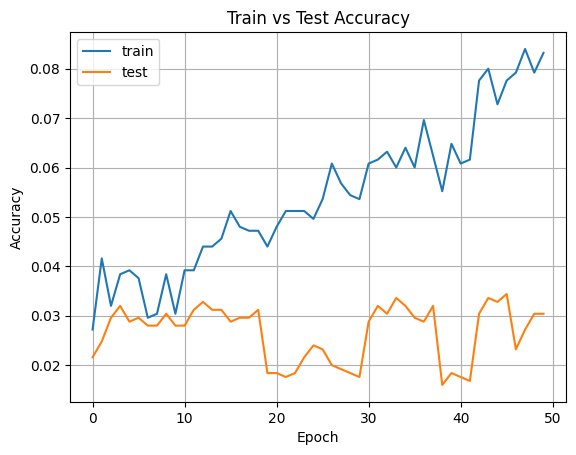

In [97]:
plot_acc(train_accs, test_accs)